# Анализ пространственных данных. Домашнее задание №2

Мягкий дедлайн: __4 ноября 2020 г. 23:59__

Жесткий дедлайн (со штрафом в _50%_ от количества набранных вами за ДЗ баллов): __5 ноября 2020 г. 08:59__

Визуализация "чего-либо" __без__ выполненного основного задания оценивается в __0 баллов__

ФИО: `Гайн Роман Андреевич`

Группа: `DS-11`

## Задание №1. Горячая точка (алгоритм - 10 баллов, визуализация - 10 баллов).

Генерируйте рандомные точки на планете Земля до тех пор, пока не попадете на территорию ``Афганистана``

1. Вы можете использовать функции принадлжености точки полигону и расстояния от точки до полигона (в метрах)
2. Предложите не наивный алгоритм поиска (генерировать __напрямую__ точку из полигона границ Афганистана __запрещено__)

In [150]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance
import shapely

import geopandas as gpd
import earthpy as et
from shapely.geometry import Point, LineString
from shapely.geometry import *


import osmapi as osm
from PIL import Image
import requests
from io import BytesIO
from OSMPythonTools.nominatim import Nominatim

In [64]:
#спарсим ID для relation Афганистан и Кабула
nominatim = Nominatim()
areaId_Afghanistan = nominatim.query('Afghanistan').areaId()
areaId_Kabul = nominatim.query('Kabul, Afghanistan').areaId()
print(areaId_Afghanistan)
print(areaId_Kabul)

[nominatim] downloading data: search


3600303427
3601676476


In [61]:
#Получим границы (полигон) страны Афганистана - НЕ УДАЛОСЬ

from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
overpass = Overpass()

#query = overpassQueryBuilder(area=areaId_Afghanistan, elementType='way', selector='"Members"="Border Pakistan - Afganistan"', includeGeometry=True, out='body')

query = overpassQueryBuilder(area=areaId_Afghanistan, elementType='way', selector='"Members"="Border Pakistan - Afganistan"', includeGeometry=True)#,  out='body')
result = overpass.query(query, timeout=120)

In [63]:
len([elem for elem in result.elements()])

0

In [49]:
# воспользуемся готовым датасетом по странам https://geopandas.org/mapping.html

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [173]:
world.head(104)  #проверим

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
99,157826578,Asia,Bangladesh,BGD,628400.0,"POLYGON ((92.67272 22.04124, 92.65226 21.32405..."
100,758288,Asia,Bhutan,BTN,6432.0,"POLYGON ((91.69666 27.77174, 92.10371 27.45261..."
101,29384297,Asia,Nepal,NPL,71520.0,"POLYGON ((88.12044 27.87654, 88.04313 27.44582..."
102,204924861,Asia,Pakistan,PAK,988200.0,"POLYGON ((77.83745 35.49401, 76.87172 34.65354..."


<AxesSubplot:>

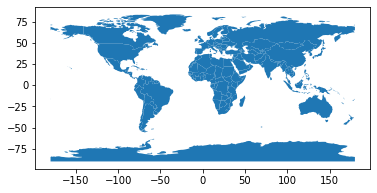

In [12]:
world.plot()

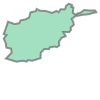

In [192]:
#посмотрим конкретно на Афганистан

num = world.loc[world['name'] == 'Afghanistan'].index.values[0]
afg_pol = world.loc[num]['geometry']
afg_pol
#afg_pol = world_1['geometry']
#afg_pol.plot()

In [208]:
# для позиционирования карты на нужны координаты Кабула
afghanistan_capital =  cities.loc[cities['name'] == 'Kabul']
x_capital = afghanistan_capital['geometry'].x
y_capital = afghanistan_capital['geometry'].y
print(x_capital)
print(y_capotal)

183    69.181314
dtype: float64
183    34.518636
dtype: float64


In [420]:
from random import uniform
import folium

#сгенерим рандомные точки
x, y = round(uniform(-180,180), 5), round(uniform(-90, 90), 5)
#x, y = 100, 100
#print(x)
#print(y)
point = Point(x, y)     #преобразуем в точку

l = []  # з аедем список, куда будем складывать нагенерированные точки
l.append(point)

while point.within(afg_pol) == False:  #пока сгенерированные точки не лежат в области полигона Афганистана
    # будем считать разницы по широте и долготе между столицей Афганисана и сгенерированной точкой
    x_point = abs(x_capital - abs(x))
    y_point = abs(y_capital - abs(y))
    x, y = round(uniform(x_capital - x_point, x_capital + x_point), 5), round(uniform(y_capital - y_point, y_capital + y_point), 5)
    point = Point(x, y)
    l.append(point)
    
len(l)

8

In [421]:
import datetime
from time import mktime
import time

# создадим DF с полученными координатами и сгенерируем timestamp для каждой точки

df = pd.DataFrame(data=None, columns=['timestamp', 'coordinates'], dtype=None, copy=False)
seconds_since_the_epochs = time.time()
for i in range(len(l)):
    t = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(seconds_since_the_epochs))    
    df.loc[i] = [t, l[i]]
    seconds_since_the_epochs += 5
df

,timestamp,coordinates
0,2020-11-03 21:33:30,POINT (21.53344 73.20542)
1,2020-11-03 21:33:35,POINT (41.84376 68.37894)
2,2020-11-03 21:33:40,POINT (90.05322 19.83502)
3,2020-11-03 21:33:45,POINT (55.33967 34.47921)
4,2020-11-03 21:33:50,POINT (58.3575 34.53347)
5,2020-11-03 21:33:55,POINT (77.25364999999999 34.50888)
6,2020-11-03 21:34:00,POINT (71.23730999999999 34.51562)
7,2020-11-03 21:34:05,POINT (70.94038 34.51692)


In [422]:
df['coordinates'][0].x

21.53344

In [423]:
# создадим функцию, кот сгенерит geojson со всеми сгенерированными точками

def create_geojson_features(df):
    features = []
    
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['coordinates'].x, row['coordinates'].y]
                #'coordinates':[row['lon'],row['lat']]
            },
            'properties': {
                'time': row['timestamp']
                #'time': pd.to_datetime(row['timestamp'], unit='h').__str__(),
                #'style': {'color' : ''},
                #'icon': 'circle',
                #'iconstyle':{
                    
                 #   'fillOpacity': 0.8,
                 #   'stroke': 'true',
                  #  'radius': 5 #+row['count']
                    #'fillColor': row['fillColor']
                #}
            }
        }
        features.append(feature)
    return features

geojson_points = create_geojson_features(df) 

In [431]:
# выведем полученный результат на карту

from folium.plugins import TimestampedGeoJson
import folium
import os

m = folium.Map(location=[y_capital, x_capital], zoom_start=2)

folium.GeoJson(
    afg_pol,
    name='geojson'   
    
).add_to(m)

TimestampedGeoJson(geojson_points,
                  period = 'PT5S', 
                  duration = 'PT3S',
                  transition_time = 1000,
                   
                  #period='P1M',
                  add_last_point=False,
                  auto_play=False,
                  loop=False,
                  max_speed=100,
                  loop_button=True,
                  date_options='YYYY/MM/DD H:M:SS',
                  time_slider_drag_update=True,
                  #duration='P2M'
                   
                  ).add_to(m)
m.save(outfile= "test.html")
m

Визуализируйте пошагово предложенный алгоритм при помощи ``Folium``

In [426]:
#сделано

## Задание №2. Качество жизни (20 баллов).

Для измерения показателя качества жизни в точке, найденной в предыдущем задании, вам необходимо рассчитать следующую сумму расстояний (в метрах):

1. Расстояние от точки до 5 ближайших __*__ банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости
2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице
3. Расстояние от точки до 5 ближайших кинотеатров, наодящихся в стране с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части __**__

__*__ При поиске _N_ ближайших объектов обязательно использовать ``R-tree``

__**__ Южной частью страны является территория, находящаяся к югу от множества точек, равноудаленных от самой северной и самой южной точек страны

In [480]:
import pandas as pd

#загрузим список стран

tables = pd.read_html("https://osmstats.neis-one.org/?item=countries&date=2-11-2020", header=0 )
#tables = pd.DataFrame(tables)
tables[0]

,No.,Country,Contributors,Created elements,Modified elements,Deleted elements
0,1.0,Seychelles,1,41,4,0
1,2.0,Samoa,1,1,3,0
2,3.0,British Indian Ocean Territory,1,0,4,1
3,4.0,Republic of Kosovo,1,1,0,0
4,5.0,Montenegro,1,1,0,0
...,...,...,...,...,...,...
255,256.0,Cameroon,0,0,0,0
256,257.0,Cook Islands,0,0,0,0
257,258.0,Turks and Caicos Islands,0,0,0,0
258,259.0,French Southern & Antarctic Lands,0,0,0,0


In [542]:
# переведем в формат DF и оставим только те, что имеют число созданных объектов от 50 000. Остальные смотреть нет смысла.

a = pd.DataFrame(tables[0])
a.sort_values(['Created elements'], ascending=[False], inplace=True)
filter_large = a['Created elements'] > 30000

b = a.loc[filter_large]
b.index = np.arange(len(b))

b['areaId'] = 0   #создам столбец для ID OSM

b

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,No.,Country,Contributors,Created elements,Modified elements,Deleted elements,areaId
0,176.0,United States,423,724940,62386,35009,0
1,171.0,Poland,174,434411,20297,7027,0
2,169.0,Australia,121,131075,13183,2929,0
3,172.0,Russia,200,125337,23301,5704,0
4,177.0,Germany,843,93251,70254,11496,0
5,175.0,France,350,90423,77496,41830,0
6,174.0,United Kingdom,228,71732,23160,3236,0
7,170.0,Spain,130,63317,12634,29642,0
8,145.0,Kenya,34,60080,9433,12007,0
9,160.0,Indonesia,74,55597,11825,4996,0


In [543]:
#country = list(b['Country'])

#найдем срану, с максимальным количесттвом объектов, удовлетворяющую условию задачи (ID заканчивается на "0")

for i in range(len(b['Country'])):
    country = b['Country'][i]
    areaId = nominatim.query(country).areaId()
    b['areaId'][i] = areaId
    
b

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search


,No.,Country,Contributors,Created elements,Modified elements,Deleted elements,areaId
0,176.0,United States,423,724940,62386,35009,3600148838
1,171.0,Poland,174,434411,20297,7027,3600049715
2,169.0,Australia,121,131075,13183,2929,3600080500
3,172.0,Russia,200,125337,23301,5704,3600060189
4,177.0,Germany,843,93251,70254,11496,3600051477
5,175.0,France,350,90423,77496,41830,3602202162
6,174.0,United Kingdom,228,71732,23160,3236,3600062149
7,170.0,Spain,130,63317,12634,29642,3601311341
8,145.0,Kenya,34,60080,9433,12007,3600192798
9,160.0,Indonesia,74,55597,11825,4996,3600304751


#### `согласно условиям задачи, скорее всего подойдут страны Автралия, Норвегия (Бразилия уже понятно, что слишком далеко, а Танзания точно не вариант)`

In [622]:
#В Автстралии кол-во объектов в 2.5 раза больше, чем в Норвегии. Проверим, кол-во объектов жилой недвизимости.

australia_houses1 = 0
query_Australia1 = overpassQueryBuilder(area=3600080500, elementType='node', selector='"building"~"apartments|house|residential"', out='count')
result_Australia1 = overpass.query(query_Australia1)
count1 = result_Australia1.countElements()
australia_houses1 += count1
print('australia_houses =', australia_houses1)

norway_houses1 = 0
query_Norway_houses1 = overpassQueryBuilder(area=3602978650, elementType='node', selector='"building"~"apartments|house|residential"', out='count')
result_Norway_houses1 = overpass.query(query_Norway_houses1)
count2 = result_Norway_houses1.countElements()
norway_houses1 += count2
print('norway_houses =', norway_houses1)



australia_houses = 3964
norway_houses = 380


#### вывод: в Австралии намного больше объектов типа недвижимость. Вероятно, с аптеками и школами - та же история.

In [1]:
# не доделал(

## Задание №3. Поездка по Нью-Йорку (маршрут - 20 баллов, визуализация - 10 баллов).

Добраться __на автомобиле__ от входа в ``Central Park`` __Нью-Йорка__ (со стороны ``5th Avenue``) до пересечения ``Water Street`` и ``Washington Street`` в Бруклине (откуда получаются лучшие фото Манхэттенского моста) довольно непросто - разумеется, из-за вечных пробок. Однако еще сложнее это сделать, проезжая мимо школ, где дети то и дело переходят дорогу в неположенном месте.

Вам необходимо построить описанный выше маршрут, избегая на своем пути школы. Визуализируйте данный маршрут (также добавив школы и недоступные для проезда участки дорог) при помощи ``Folium``

Данные о расположении школ Нью-Йорка можно найти [здесь](https://catalog.data.gov/dataset/2019-2020-school-point-locations)

In [2]:
import json
import requests

import folium
import pyproj
from shapely import geometry
from shapely.geometry import Point, LineString, Polygon, MultiPolygon

from openrouteservice import client
from pyproj import CRS
from pyproj import Proj, transform
from pyproj import Transformer

In [3]:
# 

url = 'https://data.cityofnewyork.us/api/views/a3nt-yts4/rows.json'

api_key = '5b3ce3597851110001cf6248d799ba93e9034439b0f6fa05282cedac' 
clnt = client.Client(key=api_key) # Create client with api key
school_json = requests.get(url).json() # Get data as JSON

In [5]:

# Function to create buffer around tweet point geometries and transform it to the needed coordinate system (WGS84)

def CreateBufferPolygon(point_in, resolution=10, radius=10):    #2 and 20

    sr_wgs = pyproj.Proj(init='epsg:4326')
    sr_utm = pyproj.Proj(init='epsg:32632') # WGS84 UTM32N
    
#     transformer_dir = Transformer.from_crs('epsg:4326','epsg:32632', always_xy=True)
#     point_in_proj = transformer_dir.transform(*point_in)    
    
    point_in_proj = pyproj.transform(sr_wgs, sr_utm, *point_in) # unpack list to arguments

    point_buffer_proj = Point(point_in_proj).buffer(radius, resolution=resolution) # 10 m buffer
    
    # Iterate over all points in buffer and build polygon
    poly_wgs = []
    for point in point_buffer_proj.exterior.coords:
        poly_wgs.append(pyproj.transform(sr_utm, sr_wgs, *point)) # Transform back to WGS84
        #poly_wgs.append(transformer_dir.transform(*point_in)) # Transform back to WGS84

    return poly_wgs


# Function to request directions with avoided_polygon feature
def CreateRoute(avoided_point_list, n=0):
    route_request = {'coordinates': coordinates, 
                    'format_out': 'geojson',
                    'profile': 'driving-car',
                    'preference': 'shortest',
                    'instructions': False,
                     'options': {'avoid_polygons': geometry.mapping(MultiPolygon(avoided_point_list))}} 
    route_directions = clnt.directions(**route_request)
    
    return route_directions


# Function to create buffer around requested route
def CreateBuffer(route_directions): 
    line_tup = []
    for line in route_directions['features'][0]['geometry']['coordinates']:
        tup_format = tuple(line)
        line_tup.append(tup_format)  

    new_linestring = LineString(line_tup)
    dilated_route = new_linestring.buffer(0.001)
        
    return dilated_route

In [637]:


m = folium.Map( location=([40.7771130, -73.9636667]), zoom_start=13) # Create map

sites_poly = []
school_geometry = []
for i in range(len(school_json['data'])):
    local_coord = []
   
    local_coord.append(float(school_json['data'][i][8].split(' ', maxsplit=3)[1][1:]))   
    local_coord.append(float(school_json['data'][i][8].split(' ', maxsplit=3)[2][:-1]))
    local_coord
    
    folium.CircleMarker(list(reversed(local_coord)), radius=2, popup='Shcool', color='red', fill=True, fill_color='#3186cc').add_to(m)
    
# Create buffer polygons around affected sites with 20 m radius and low resolution
    school_poly = CreateBufferPolygon(local_coord, resolution=2, radius=10)
    sites_poly.append(school_poly)
    
    
#Create simplify geometry and merge overlapping buffer regions
poly = Polygon(sites_poly)  
school_geometry.append(poly)

union_poly = mapping(cascaded_union(school_geometry)) 

folium.features.GeoJson(data=union_poly,
                        name='Schools areas',
                        style_function=style_function('#ffd699'),).add_to(m)
    
    #     folium.Marker(list(reversed(local_coord)),
# #                            icon=folium.Icon(color='lightgray',
# #                                     icon_color='red',
# #                                     icon='twitter',
# #                                     prefix='fa'),                           
#                            popup='Shcool<br>{0}'.format(local_coord)).add_to(m)
        

# folium.Marker(list(reversed(data['geometry']['coordinates'][0])),
#                       icon=folium.Icon(color='lightgray',
#                                     icon_color='red',
#                                     icon='twitter',
#                                     prefix='fa'),
#                       popup=data['properties']['tweet']).add_to(map_tweet)

# minimap = MiniMap(toggle_display=True)
# minimap.add_to(m)

m